In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

def random_walk(length, interval=1, p=0.5, amplitude=1,
                acceleration=0.5, pre=(-1,1), post=(-1,3)):
    pre = interval*np.array(pre)
    post = interval*np.array(post)
    
    #xvals = np.arange(0, length) # *interval
    split = np.random.choice(np.arange(int(0.3*length), int(0.7*length)))
    pre_intervention = np.random.choice(pre, split, p=(1-p, p))
#     if np.random.choice((-1,1)) > 0:
#         accel = (1-acceleration, acceleration)
#     else:
    accel = (acceleration, 1-acceleration)
    label = np.random.choice((0,1))
    if label==0:
        post = (np.sign(post[0])*np.abs(post[1]),np.sign(post[1])*np.abs(post[0]))
    post_intervention = np.random.choice(post, (length-split), p=accel)
    
    yvals = np.cumsum(np.concatenate([pre_intervention, post_intervention]))
    
    return yvals, label

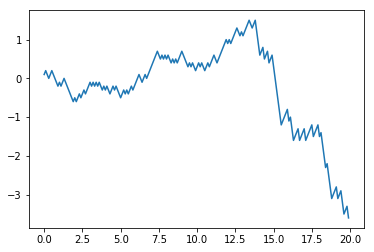

In [2]:
y, _ = random_walk(200, post=(-1,3), interval=0.1)
plt.plot(0.1*np.arange(200),y)

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def sequenceGenerator(nseq, length, **kwargs):
    seqs = []
    labels = []
    for i in range(nseq):
        walk, label = random_walk(length, **kwargs)
        seqs.append(walk)
        labels.append(label)
    return np.stack(seqs), np.array(labels)

class Autoregressor(nn.Module):
    def __init__(self, numIn):
        super(Autoregressor, self).__init__()
        self.main = nn.Linear(numIn, 1)
        
    def forward(self, x):
        return self.main(x).squeeze(1)
    
class SequenceLoader(Dataset):
    def __init__(self, dataX, dataY, numPerSample, normalize=True):
        super(SequenceLoader, self).__init__()
        self.data = torch.Tensor(dataX)
        self.labels = torch.Tensor(dataY)
        self.n = numPerSample
        self.convsize = self.data.size(1)-self.n+1
        self.length = self.data.size(0)*self.convsize
        self.normalize = normalize
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        j = i//self.convsize
        k = i%self.convsize
        x = self.data[j,k:(k+self.n)]
        y = self.labels[j]
        if self.normalize:
            x = x/np.linalg.norm(x)
        return x, y
    
def train(net, dset, batchsize=64, lr=0.002, betas=(0.5,0.999),
          nepoch=10, saveloc='./autoregressor.pth',printevery=100):
    
    net.train()
    loader = DataLoader(dset, shuffle=True, batch_size=64, num_workers=1)
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=betas)
    lossfunc = nn.BCEWithLogitsLoss()

    for epoch in range(nepoch):
        for i, data in enumerate(loader):
            x, y = data
           # print(x,y)
            net.zero_grad()
            preds = net(x)
           # print(preds)
            loss = lossfunc(preds,y)
            loss.backward()
            optimizer.step()
            
            if i%printevery == 0:
         #       print(preds[:5], y[:5])
                print("  ",loss.item())
                
    torch.save(net.state_dict(), saveloc)
    #return net
            
def test(net, dset):
    net.eval()
    allpts = []
    for i in range(len(dset)):
        x, _ = dset[i]
        allpts.append(x)
    allpts = torch.stack(allpts)
    print(allpts.size())
    allpreds = net(allpts)
    plt.plot(torch.sigmoid(allpreds).detach().numpy())
    plt.figure()
    
            


In [117]:
h = 30
x, y = sequenceGenerator(100,200, post=(-1,2.5))

torch.Size([171, 30])
   0.6968700885772705
   0.5459793210029602
   0.5700721144676208
   0.5578219890594482
   0.5706068277359009
   0.4515874683856964
   0.5373112559318542
   0.5482689142227173
   0.6654294729232788
   0.5455183982849121
   0.4194490313529968
   0.6242567300796509
   0.5850179195404053
   0.5384799838066101
   0.533518373966217
   0.44318652153015137
   0.5598164796829224
   0.47747138142585754
   0.4716413915157318
   0.5579172968864441
torch.Size([171, 30])
0


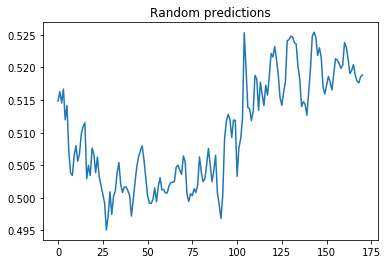

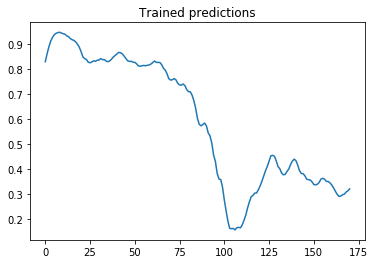

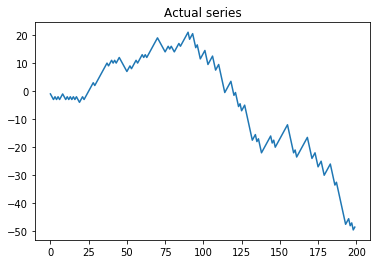

In [118]:
trainset = SequenceLoader(x[:-2],y[:-2],h,normalize=True)
testset = SequenceLoader([x[-1]],[y[-1]],h,normalize=True)
net = Autoregressor(h)
plt.title("Random predictions")
test(net,testset)
train(net,trainset,nepoch=20,printevery=500)
plt.title("Trained predictions")
test(net,testset)
plt.title("Actual series")
plt.plot(x[-1])
print(y[-1])


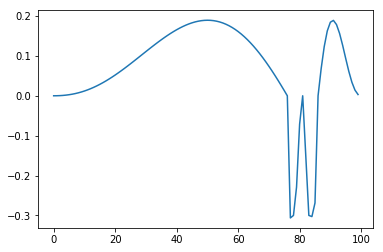

In [49]:
def quinticSpline(indices, y, yprime, yprimeprime):
    assert(len(indices)==len(y))
    assert(len(yprime)==len(y))
    assert(len(yprimeprime)==len(y))
    
    # The round and divide fixes slight numerical errors and is probably unnecessary
    Minv = np.round(2*np.linalg.inv(np.array([[1,0,0,0,0,0],[1,1,1,1,1,1],[0,1,0,0,0,0],
                                   [0,1,2,3,4,5],[0,0,2,0,0,0],[0,0,2,6,12,20]])))/2
    
    pts = []
    for i in range(len(y)-1):
        targets = np.array([y[i],y[i+1],yprime[i],yprime[i+1],yprimeprime[i],yprimeprime[i+1]])
        coeffs = np.dot(Minv, targets)
        r = indices[i+1]-indices[i]
        s = np.arange(r)/r
        s2 = s*s
        s3 = s*s2
        s4 = s*s3
        s5 = s*s4
        yvals = coeffs[5]*s5 + coeffs[4]*s4 + coeffs[3]*s3+coeffs[2]*s2+coeffs[1]*s+coeffs[0]
        pts.append(yvals)
        
    return np.concatenate(pts)

def random_spline(length, amplitude=0.5, bumplength=24, y=None):
    if y is None:
        y = np.random.choice((0,1))
    place = np.random.choice(np.arange(0,length-bumplength))
    if y==0:
        x=quinticSpline([0,place,place+bumplength//2,place+bumplength,length],
                        [0,0,amplitude,0,0],[0,1,0,-1,0],[-1,1,-1,1,-1])
    else:
        x=quinticSpline([0,place,place+bumplength//2,place+bumplength,length],
                        [0,0,-amplitude,0,0],[0,-1,0,1,0],[1,-1,1,-1,1])
    return x, y

def random_asymmetric_spline(length, amplitude=0.5, bumplength=24, y=None):
    if y is None:
        y = np.random.choice((0,1))
    place = np.random.choice(np.arange(0,length-bumplength))
    if y==1:
        x=quinticSpline([0,place,place+bumplength//2,place+bumplength,length],
                        [0,0,amplitude,0,0],[0,1,0,-1,0],[-1,1,-1,1,-1])
    else:
        x=quinticSpline([0,place,place+bumplength//4,place+bumplength//2,
                         place+(3*bumplength)//4, place+bumplength, length],
                        [0,0,-amplitude/2,0,-amplitude/2,0,0],
                        [0,-1,0,0,0,1,0],
                        [1,-1,1,-1,1,-1,1])
    return x, y

def spline_generator(nseq, length):
    seqs = []
    labels = []
    for i in range(nseq):
        walk, label = random_spline(length)
        walk = walk+np.random.normal(0,0.05,(length))
        seqs.append(walk)
        labels.append(label)
    return np.stack(seqs), np.array(labels)

def asymmetric_spline_generator(nseq, length):
    seqs = []
    labels = []
    for i in range(nseq):
        walk, label = random_asymmetric_spline(length)
        walk = walk+np.random.normal(0,0.05,(length))
        seqs.append(walk)
        labels.append(label)
    return np.stack(seqs), np.array(labels)

#seq = quinticSpline([0,20,50,70,100], [-10,4,6,-9,-14],[0,20,-10,-20,0],[0,1,-1,1,0])
#plt.plot(np.arange(len(seq)), seq, '-')
seq, _ = random_asymmetric_spline(100, amplitude=0.6, bumplength=10)
#print(seq)
plt.plot(seq)



Testing random model
torch.Size([171, 30])
torch.Size([171, 30])
   0.7271357178688049
   0.4917406439781189
   0.4401624798774719
   0.3636208176612854
   0.4895904064178467
   0.34411391615867615
   0.48197686672210693
   0.43951907753944397
   0.3791763186454773
   0.32823845744132996
   0.41639626026153564
   0.42201951146125793
   0.4841487407684326
   0.3966699242591858
   0.4211663007736206
   0.428711861371994
   0.4312363862991333
   0.3904646635055542
   0.3823662996292114
   0.4635116457939148
Testing trained model
torch.Size([171, 30])
torch.Size([171, 30])
The test pt


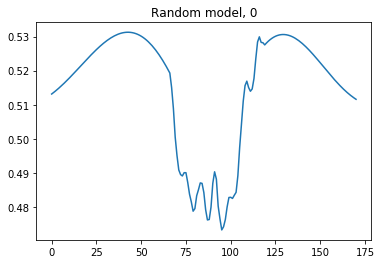

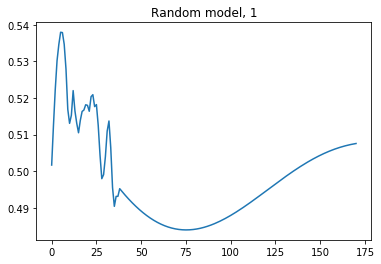

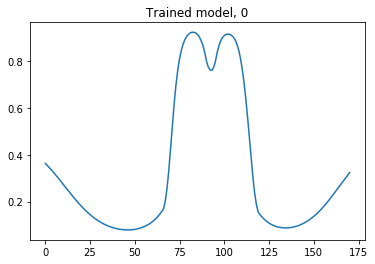

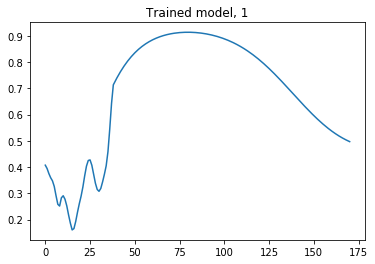

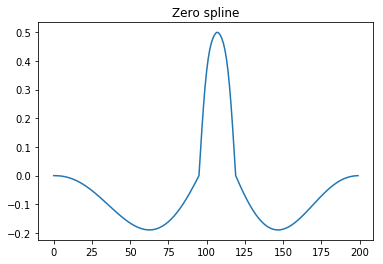

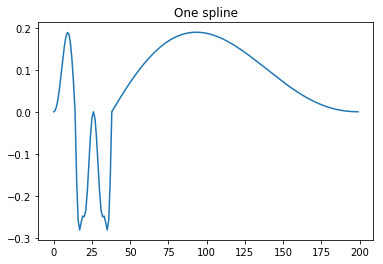

In [53]:
h = 30
x, y = asymmetric_spline_generator(100,200)
trainset = SequenceLoader(x[:-2],y[:-2],h,normalize=True)
#print("The first few training ys")
#x0,y0 = trainset[0]
#plt.plot(x0.numpy())
#print("First pt", y0.item())
#x1, y1 = trainset[1]
#print("second pt", y1.item())
#plt.figure()
net = Autoregressor(h)
print("Testing random model")
# zeroSpline, _ = random_spline(200, y=0)
# oneSpline, _ = random_spline(200, y=1)
zeroSpline, _ = random_asymmetric_spline(200, y=0)
oneSpline, _ = random_asymmetric_spline(200, y=1)
testset0 = SequenceLoader([zeroSpline],[0], h, normalize=False)
testset1 = SequenceLoader([oneSpline], [1], h, normalize=False)
plt.title("Random model, 0")
test(net,testset0)
#plt.figure()
plt.title("Random model, 1")
test(net,testset1)
#plt.figure()
train(net,trainset,nepoch=20,printevery=500)
print("Testing trained model")
plt.title("Trained model, 0")
test(net,testset0)
plt.title("Trained model, 1")
test(net, testset1)
#plt.figure()
print("The test pt")
plt.title("Zero spline")
plt.plot(zeroSpline)
plt.figure()
plt.title("One spline")
plt.plot(oneSpline)

0


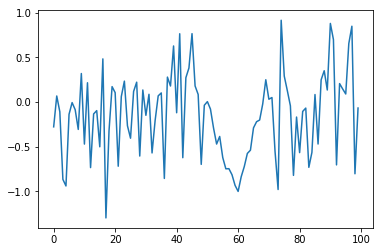

In [82]:
def random_bump(length, amplitude=1, bumplength=20, stdev=0.5, y=None):
    if y is None:
        y = np.random.choice((0,1))
    leftx = np.random.choice(np.arange(0,length-bumplength))
    midx = leftx+bumplength//2
    rightx = leftx+bumplength
    slope1 = amplitude/(midx-leftx)
    slope2 = -amplitude/(rightx-midx)
    firstarc = slope1*(np.arange(leftx,midx)-leftx)
    secondarc = slope2*(np.arange(midx,rightx)-rightx)
    
    x = np.concatenate([np.zeros(leftx),firstarc,secondarc,np.zeros(length-rightx)])
    if y == 0:
        x = -x
    randvec1 = np.random.normal(0,stdev,(leftx))
    randvec2 = np.random.normal(0,0.2*stdev,(rightx-leftx))
    randvec3 = np.random.normal(0,stdev,(length-rightx))
    randvec = np.concatenate([randvec1, randvec2, randvec3])
    x = x + randvec
    return x, y

def dset_generator(nseq, length, stdev=0.1):
    seqs = []
    labels = []
    for i in range(nseq):
        walk, label = random_bump(length, stdev=stdev)
        seqs.append(walk)
        labels.append(label)
    return np.stack(seqs), np.array(labels)

b, y = random_bump(100)
print(y)
plt.plot(b)

Testing random model
torch.Size([171, 30])
torch.Size([171, 30])
   0.6836992502212524
   0.6464166045188904
   0.5692130923271179
   0.6170923709869385
   0.6292770504951477
   0.587608814239502
   0.6423409581184387
   0.592241108417511
   0.6365593075752258
   0.5860610604286194
   0.6085366010665894
   0.6857502460479736
   0.617263674736023
   0.622882604598999
   0.5773511528968811
   0.5419162511825562
   0.6129189133644104
   0.5533156991004944
   0.6427557468414307
   0.5880502462387085
Testing trained model
torch.Size([171, 30])
torch.Size([171, 30])
The test pt


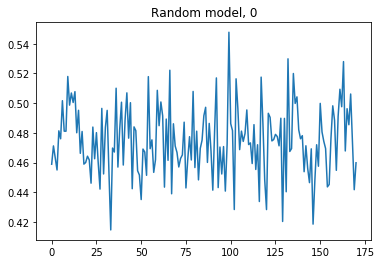

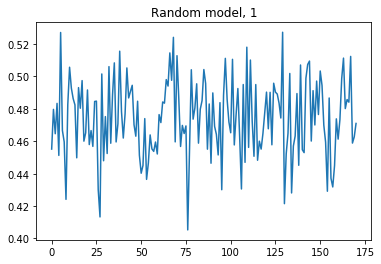

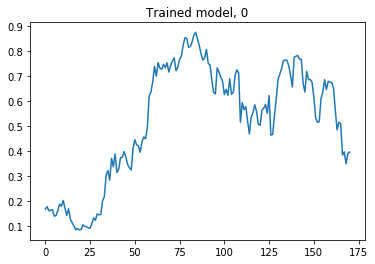

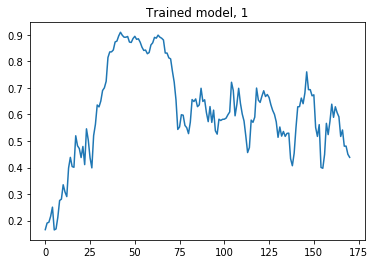

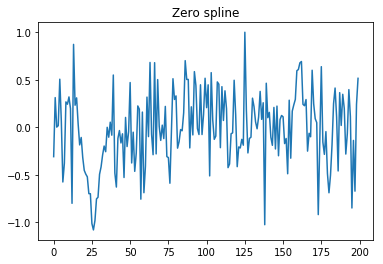

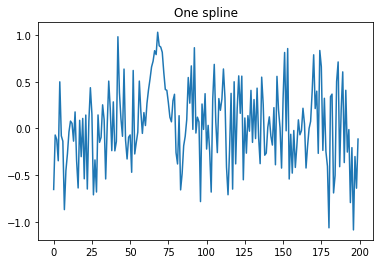

In [91]:
h = 30
stdev=0.4
x, y = dset_generator(100,200, stdev=stdev)
trainset = SequenceLoader(x,y,h,normalize=True)

net = Autoregressor(h)
print("Testing random model")
# zeroSpline, _ = random_spline(200, y=0)
# oneSpline, _ = random_spline(200, y=1)
zeroSpline, _ = random_bump(200, y=0, stdev=stdev)
oneSpline, _ = random_bump(200, y=1, stdev=stdev)
testset0 = SequenceLoader([zeroSpline],[0], h, normalize=True)
testset1 = SequenceLoader([oneSpline], [1], h, normalize=True)
plt.title("Random model, 0")
test(net,testset0)
#plt.figure()
plt.title("Random model, 1")
test(net,testset1)
#plt.figure()
train(net,trainset,nepoch=20,printevery=500)
print("Testing trained model")
plt.title("Trained model, 0")
test(net,testset0)
plt.title("Trained model, 1")
test(net, testset1)
#plt.figure()
print("The test pt")
plt.title("Zero spline")
plt.plot(zeroSpline)
plt.figure()
plt.title("One spline")
plt.plot(oneSpline)